In [7]:
from sklearn.discriminant_analysis import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from fall_detection.fall.detection import StateDetector
from fall_detection.pose import YoloPoseModel, PoseLandmarksGenerator
from fall_detection.fall import PoseEmbedder, EstimatorClassifier
from fall_detection.fall import load_pose_samples_from_dir
from fall_detection.fall.embedding import COCO_POSE_KEYPOINTS
from fall_detection.utils import load_image, save_image

# run pipeline
from fall_detection.fall.pipeline import Pipeline
from fall_detection.object_detection import YoloObjectDetector
import matplotlib.pyplot as plt

In [4]:
# load sample image
image = load_image("../tests/test_data/fall-sample.png")

In [8]:
pose_model = YoloPoseModel(model_path="../models/yolov8n-pose.pt")

results = pose_model.predict(image)

img_out = pose_model.draw_landmarks(image, results)
print(img_out.shape)

(684, 944, 3)


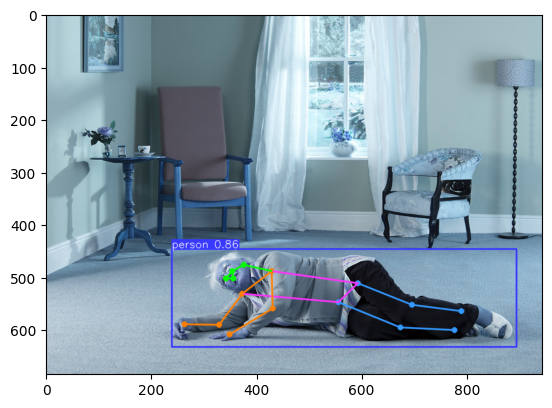

In [11]:
import cv2

plt.imshow(img_out)

In [ ]:
object_model = YoloObjectDetector(model_name="yolov8n.pt")

results = object_model(image)

img_out = object_model.draw_results(image, results)

save_image(img_out, "../data/img_object_out.png")

In [ ]:
# generate data for training
pose_sample_generator = PoseLandmarksGenerator(
    images_in_folder="./data/test_dataset",
    images_out_folder="./data/test_dataset_out",
    csvs_out_folder="./data/test_dataset_csv",
    per_pose_class_limit=4,
)

pose_sample_generator(pose_model=pose_model)

In [ ]:
# train classifier
pose_embedder = PoseEmbedder(landmark_names=COCO_POSE_KEYPOINTS)

classification_model = EstimatorClassifier(
    estimator=make_pipeline(StandardScaler(), LogisticRegression(random_state=42)),
    pose_embedder=pose_embedder,
)

detector = StateDetector(class_name="fall", enter_threshold=8, exit_threshold=4)

pose_samples = load_pose_samples_from_dir(
    pose_embedder=pose_embedder,
    n_dimensions=3,
    n_landmarks=17,
    landmarks_dir="./data/test_dataset_csv",
    file_extension="csv",
    file_separator=",",
)
classification_model.fit(pose_samples)

In [ ]:
# run prediction

pose_results = pose_model.predict(image)

pose_landmarks = pose_model.results_to_pose_landmarks(
    pose_results, image.shape[0], image.shape[1]
)

prediction = classification_model.predict(pose_landmarks)

In [ ]:
pipeline = Pipeline(
    pose_model=pose_model,
    object_model=object_model,
    classification_model=classification_model,
    detector=detector,
)

pipeline(image)

In [ ]:
# Open the video.
import cv2
import numpy as np
import tqdm
from fall_detection.fall.plot import PoseClassificationVisualizer

path_video_in = "../data/uri.mp4"
path_video_out = "../data/uri_out.mp4"

video_cap = cv2.VideoCapture(path_video_in)

# Get some video parameters to generate output video with classificaiton.
video_n_frames = video_cap.get(cv2.CAP_PROP_FRAME_COUNT)
video_fps = video_cap.get(cv2.CAP_PROP_FPS)
video_width = int(video_cap.get(cv2.CAP_PROP_FRAME_WIDTH))
video_height = int(video_cap.get(cv2.CAP_PROP_FRAME_HEIGHT))


# Initialize renderer.
pose_classification_visualizer = PoseClassificationVisualizer(
    class_name="Fall",
    plot_x_max=video_n_frames,
    plot_y_max=10,
)

out_video = cv2.VideoWriter(
    path_video_out,
    cv2.VideoWriter_fourcc(*"mp4v"),
    video_fps,
    (video_width, video_height),
)

frame_idx = 0
output_frame = None
with tqdm.tqdm(total=video_n_frames, position=0, leave=True) as pbar:
    while True:
        # Get next frame of the video.
        success, input_frame = video_cap.read()
        if not success:
            break

        # Run pose tracker.
        input_frame = cv2.cvtColor(input_frame, cv2.COLOR_BGR2RGB)

        output_frame = input_frame.copy()

        results = pipeline(input_frame)

        if results["classification"] is not None:
            # Draw classification plot and repetition counter.
            output_frame = pose_classification_visualizer(
                frame=output_frame,
                pose_classification=results["classification"],
                pose_classification_filtered=results["smooth_classification"],
                detector_state=results["detection"],
            )

        # Save the output frame.
        out_video.write(cv2.cvtColor(np.array(output_frame), cv2.COLOR_RGB2BGR))

        frame_idx += 1
        pbar.update()

# Close output video.
out_video.release()